In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# Load the CSV files
arc_df = pd.read_csv('arc_freqs.csv')

arc_df = arc_df[arc_df['num'] >= 1000]

PEAK2NOISE = 3
MIN_AMPLITUDE = 3000

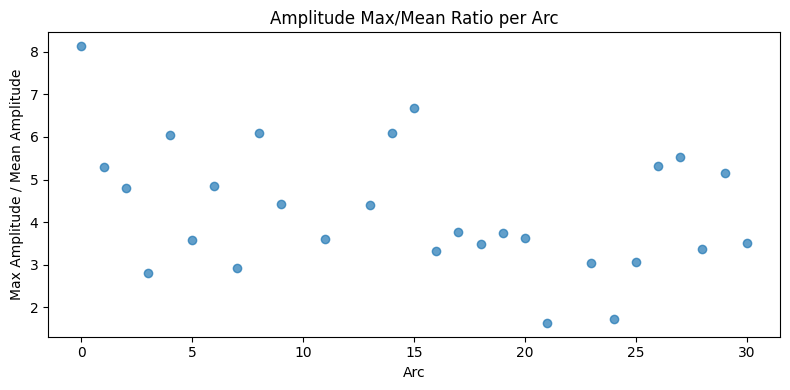

In [38]:
arc_max_mean_ratio = arc_df.groupby('i')['amplitude'].max() / arc_df.groupby('i')['amplitude'].mean()
plt.figure(figsize=(8, 4))
plt.scatter(arc_max_mean_ratio.index, arc_max_mean_ratio.values, alpha=0.7)
plt.xlabel('Arc')
plt.ylabel('Max Amplitude / Mean Amplitude')
plt.title('Amplitude Max/Mean Ratio per Arc')
plt.tight_layout()
plt.show()

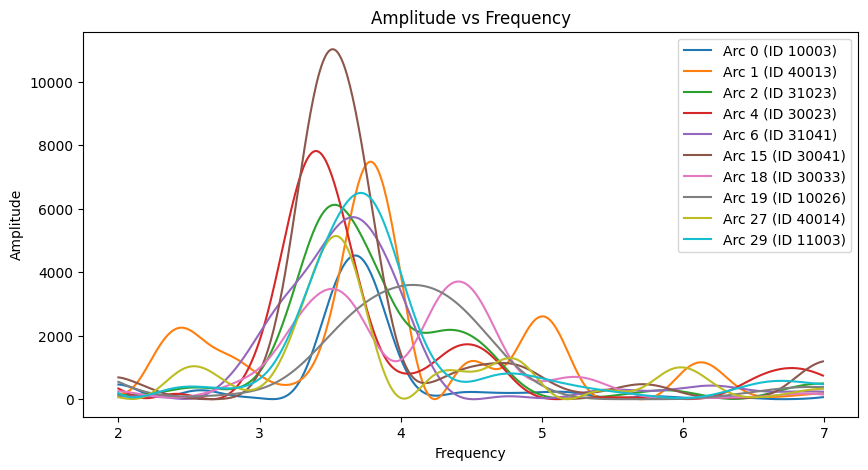

In [54]:
arc_df_filtered = arc_df.groupby('i').filter(
    lambda group: group['amplitude'].max() >= PEAK2NOISE * group['amplitude'].mean() and group['amplitude'].max() >= MIN_AMPLITUDE
)

idx = arc_df_filtered.groupby('i')['amplitude'].idxmax()
max_amp_freqs = arc_df_filtered.loc[idx, ['i','id', 'frequency', 'amplitude','num']]
Q1_freq = max_amp_freqs['frequency'].quantile(0.25)
Q3_freq = max_amp_freqs['frequency'].quantile(0.75)
IQR_freq = Q3_freq - Q1_freq
lower_freq = Q1_freq - 1.5 * IQR_freq
upper_freq = Q3_freq + 1.5 * IQR_freq

# col 0 = id, col 1 = frequency, col 2 = amplitude
plt.figure(figsize=(10, 5))
for arc in arc_df_filtered['i'].unique():
    peak_freq = max_amp_freqs[max_amp_freqs['i'] == arc]['frequency'].values[0]
    if lower_freq <= peak_freq <= upper_freq:
        arc_data = arc_df_filtered[arc_df_filtered['i'] == arc]
        plt.plot(arc_data['frequency'], arc_data['amplitude'], label=f'Arc {arc} (ID {arc_data['id'].values[0]})')

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Frequency')
plt.legend()
plt.show()

In [55]:
# Find the frequency with the highest amplitude per id
idx = arc_df.groupby('i')['amplitude'].idxmax()
max_amp_freqs = arc_df.loc[idx, ['i','id', 'frequency', 'amplitude','num']]


print(f"Before correction: mean = {max_amp_freqs['frequency'].mean():.4f}, std = {max_amp_freqs['frequency'].std():.4f} (n={max_amp_freqs.shape[0]})")

max_amp_freqs = max_amp_freqs[max_amp_freqs.apply(
    lambda row: row['amplitude'] >= PEAK2NOISE * arc_df[arc_df['i'] == row['i']]['amplitude'].mean() and row['amplitude'] >= MIN_AMPLITUDE, axis=1
)]

print(f"After amplitude filter: mean = {max_amp_freqs['frequency'].mean():.4f}, std = {max_amp_freqs['frequency'].std():.4f} (n={max_amp_freqs.shape[0]})")

# Remove outliers from the frequencies using the IQR method
Q1 = max_amp_freqs['frequency'].quantile(0.25)
Q3 = max_amp_freqs['frequency'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(upper_bound, lower_bound)
max_amp_freqs = max_amp_freqs[(max_amp_freqs['frequency'] >= lower_bound) & (max_amp_freqs['frequency'] <= upper_bound)]

# Calculate average and standard deviation of these frequencies
avg_freq = max_amp_freqs['frequency'].mean()
std_freq = max_amp_freqs['frequency'].std()

print(f"After IQR: mean = {avg_freq:.4f}, std = {std_freq:.4f} (n={len(max_amp_freqs)})")

Before correction: mean = 3.5125, std = 0.8328 (n=28)
After amplitude filter: mean = 3.7264, std = 0.7773 (n=14)
4.753749999999941 2.7837499999999844
After IQR: mean = 3.7340, std = 0.3041 (n=10)


In [10]:
records = pd.read_csv('records.csv', header=1, names=["id", "time", "network", "band", "elevation", "azimuth", "snr"])


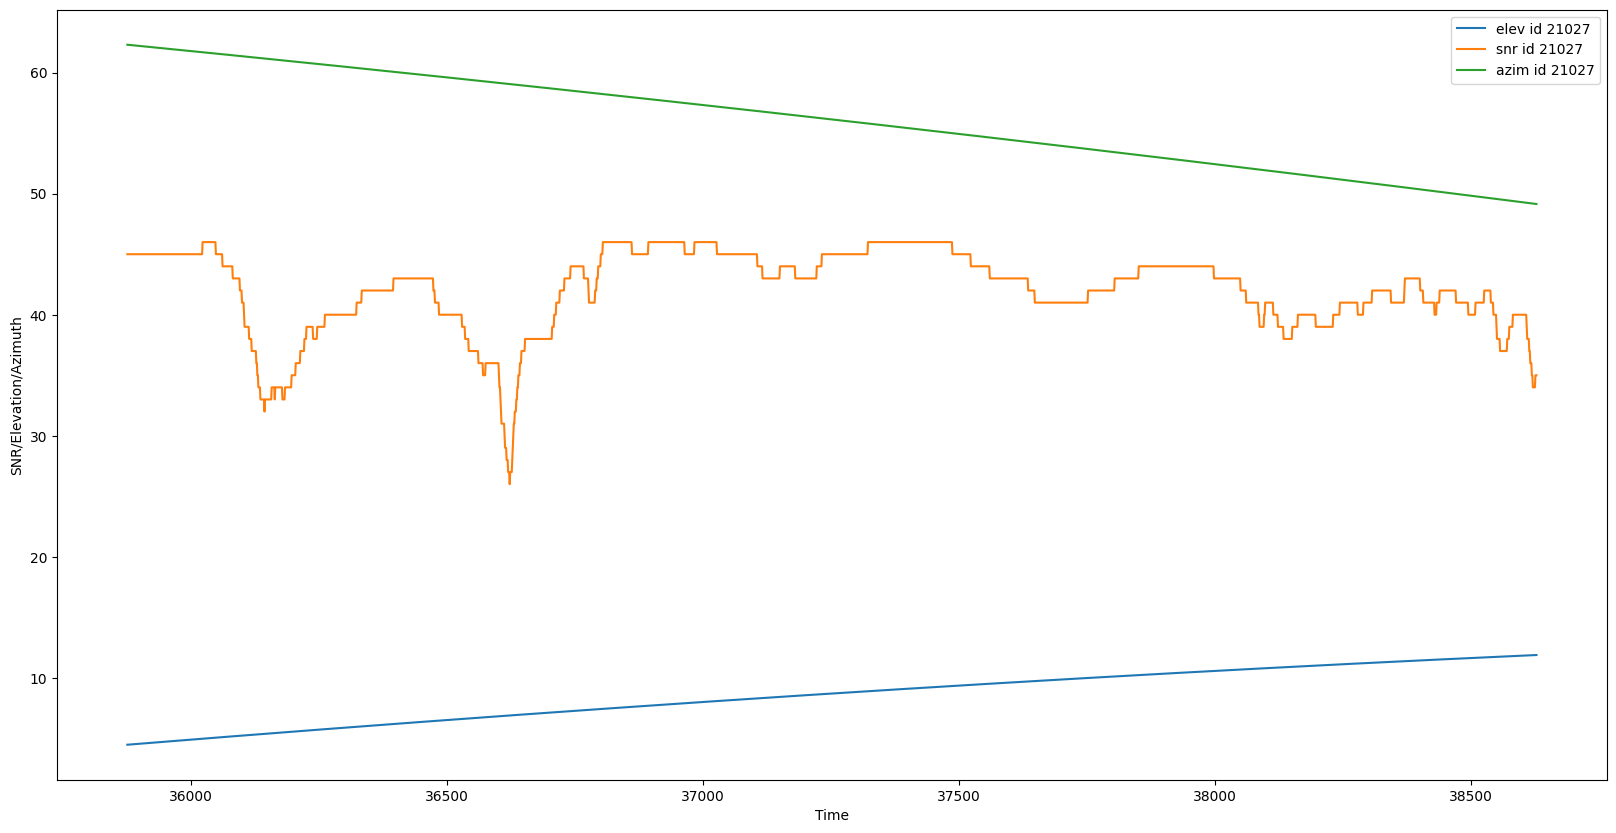

In [11]:
plt.figure(figsize=(20, 10))
for id_val in records['id'].unique():
    if id_val != 21027:
        continue
    # if str(id_val)[:2] not in ["11", "21", "31", "41", "51", "61", "71", "81", "91"]:
    #     continue
    id_data = records[records['id'] == id_val]
    plt.plot(id_data['time'], id_data['elevation'], label=f'elev id {id_val}')
    plt.plot(id_data['time'], id_data['snr'], label=f'snr id {id_val}')
    plt.plot(id_data['time'], id_data['azimuth'], label=f'azim id {id_val}')

    # break # Remove this line to plot all ids

plt.xlabel('Time')
plt.ylabel('SNR/Elevation/Azimuth')
plt.legend()
plt.show()

In [26]:
import re

with open('../data/nmea5.log', 'r', encoding='utf-8', errors='ignore') as infile:
    lines = infile.readlines()

pattern = re.compile(r'^\$.*\*[A-Za-z0-9]{2}$')
filtered_lines = [line for line in lines if pattern.match(line.strip())]

with open('../data/nmea5.txt', 'w') as outfile:
    outfile.writelines(filtered_lines)